# Decay-chain problem

## Problem description

This benchmark is meant to model the diffusive migration of the radionuclides of a simplified Curium-247 decay chain through a semi-infinite porous media column (1-D). The diagram below shows the simplified Curium-247 decay chain which contains 6 radionuclides ending with Actinium-227. All following nuclides have half-lives below 20 a and are neglected for this benchmark.

In [1]:
import os
import sys
import time

import DecayChainAnalytical as ana
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import vtuIO
from IPython.display import Image, display
from matplotlib.pyplot import cm

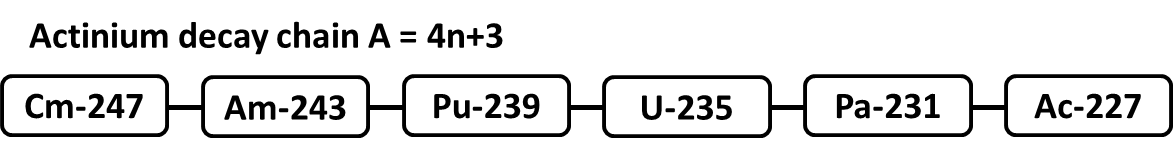

In [2]:
display(Image(filename="chains.png", width=600))

According to the mass conservation law, the reactive-diffusive transport of each member of the simplified Curium-247 decay chain can be described by:

$$
\frac{\partial \left( \phi c_{i} \right)}{\partial t} = \nabla \cdot \left(\phi \mathrm{D_p} \nabla c_{i} \right) + \phi k_{i-1} c_{i-1} - \phi k_{i} c_{i}, \quad \forall i = 1,2,...,n,
$$

where $c_{i}$ [mol/m$^3$] is the concentration of radionuclide $i$, $\phi$ [-] is the porosity, $\mathrm{D_p}$ [m$^2$/s] is the pore diffusion coefficient, and $k_{i}$ [1/s] is the first-order decay constant of a radionuclide $i$, i.e.:

$$
k_i = \mathrm{ln} 2 \, / \, t_{i,1/2},
$$

where $t_{i,1/2}$ [s] is its half life.

## Model setup

In [3]:
porosity = 0.12
diffusion_constant = 1e-11

In [4]:
# Diffusion coefficient [m2/s]
D = 1e-11
# Pore water velocity [m/s]
v = 0
# Half life [year]
radionuclides = np.array(
    ["[Cm-247]", "[Am-243]", "[Pu-239]", "[U-235]", "[Pa-231]", "[Ac-227]"]
)
half_lifes = np.array([1.56e7, 7.37e3, 2.41e4, 7.04e8, 3.28e4, 21.773])
# First-order decay constant [1/s]
k = {
    radionuclide: np.log(2) / half_life / 3.1536e7
    for radionuclide, half_life in zip(radionuclides, half_lifes)
}

###Initial and boundary conditions###
c_inlet = np.ones(6)

###Spatial and temporal discretization###
# Distance [m]
dx = np.logspace(-3, 0, 2000)
x = np.hstack(([0], np.cumsum(dx)))
x *= 20 / x[-1]
assert x[-1] == 20  # end point of the 1D mesh
assert x[0] == 0  # start point of the 1D mesh
assert abs(np.min(np.diff(x))) < 1e-3  # minimum cell size of the 1D mesh
assert abs(np.max(np.diff(x))) < 1e-1  # maximum cell size of the 1D mesh
assert np.all(np.diff(x, n=2) > 0)  # monotonically increasing cell sizes

# Time [year]
t = 1e5

In the 1-D model, the computational domain is set to be 20 meters long, which is sufficient to ensure that the concentration profile does not reach the right-hand-side boundary during simulation. The simulated time is 100 000 years. Initially, the entire domain is assumed to be solute free, i.e., $c_{\mathrm{ini}}(x, 0) = 0$ mol/m$^3$. The inlet concentration for all the radionuclides is fixed to 10$^{-3}$ mol/m$^3$ throughout the simulated time, i.e., $c(0, t) = 1$ mol/L. The spatial domain is discretized by linear line elements and the grid near the inlet is refined in order to achieve sufficiently high accuracy. A fixed time step size of one hundred years is used in the simulation. The linearized governing equation system is iteratively solved using the standard Picard iteration method.

The table below summarizes the transport parameters and spatio-temporal discretization parameters used in the simulation.

| Parameter | Value | Unit |
| :-: | :-: | :-: |
| Porosity $\phi$ | 0.12 | - |
| Pore diffusion coefficient $\mathrm{D_p}$ | 1e-11 | m$^2$/s |
| Time step size $\Delta t$ | 1e2 | year |
| Grid size $\Delta x$ | 0.00512 - 1.985 | m|

The following table lists the dataset for the half-life of the radionuclides

| Radionuclide | Half-life [year]| First-order decay constant [1/year] |
| :-: | :-: | :-: |
| Cm-247 | 1.56$\times$10$^{7}$ | 4.44$\times$10$^{-8}$ |
| Am-243 | 7.37$\times$10$^{3}$ | 9.40$\times$10$^{-5}$ |
| Pu-239 | 2.41$\times$10$^{4}$ | 2.88$\times$10$^{-5}$ |
|  U-235 | 7.04$\times$10$^{8}$ | 9.84$\times$10$^{-10}$ |
| Pa-231 | 3.28$\times$10$^{4}$ | 2.11$\times$10$^{-5}$ |
| Ac-227 | 21.773 | 3.18$\times$10$^{-2}$ |

Notes: The half-life dataset is sourced from Report GRS-289.

## Results

### Analytical solution

The analytical solution for the reactive-diffusive transport of radionuclides makes use of an expression for the reactive part developed by Sun et al. (1999) for linear reaction chains by making use of an auxiliary varibale $a_i$ and replacing $c_i$ by:

$$
c_{i} = a_{i} - \sum_{j=1}^{i-1} \prod_{l=j}^{i-1} \frac{k_{l}}{k_{l} - k_{i}} c_{j}, \quad \forall i = 2,3,...,n,
$$
in an otherwise defined analytical solution for transport.

#### Concentration profiles

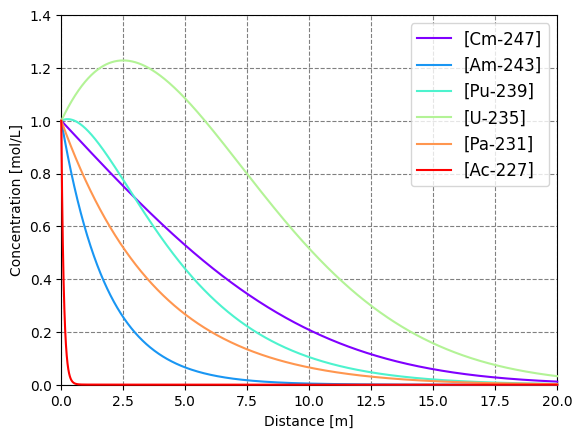

In [5]:
c = ana.computeConcentrations(x, t, v, D, k, radionuclides, c_inlet)

fig, ax = plt.subplots()

ax.set(xlim=(0, 20), ylim=(0, 1.4))
ax.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

for radionuclide, color in zip(radionuclides, color_map):
    ax.plot(
        x,
        c[radionuclide],
        linestyle="-",
        lw=1.5,
        label=radionuclide,
        c=color,
        zorder=10,
        clip_on=False,
    )

ax.legend(frameon=True, loc="upper right", numpoints=1, fontsize=12, ncol=1)

ax.xaxis.grid(color="gray", linestyle="dashed")
ax.yaxis.grid(color="gray", linestyle="dashed")

#### Concenctration gradient

In [6]:
x_mid = 0.5 * (x[:-1] + x[1:])
grad_c = ana.computeGradients(x_mid, t, v, D, k, radionuclides, c_inlet)
grad_c_num = {n: (cs[1:] - cs[:-1]) / np.diff(x) for n, cs in c.items()}

The following graph is just a self-check that the derived analytical expression for the gradient of the analytical solution is correct.
The left plot shows both the analytical and numerical (central differences) gradient of the analytical solution for all nuclide concentrations.
The center plot shows the difference between analytical and numerical gradients,
and the right one the difference normalized to the range in which the numerical gradient varies.
This normalized error is smaller than $10^{-6}$ for all nuclides.

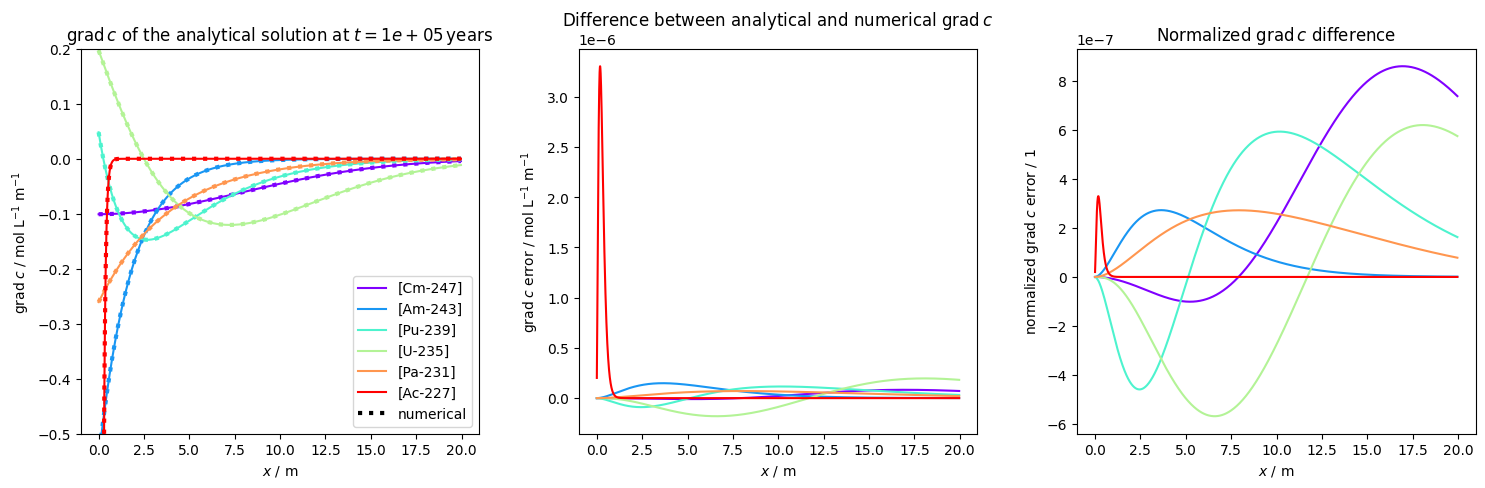

In [7]:
color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

fig, (ax, ax2, ax3) = plt.subplots(1, 3)

for name, color in zip(radionuclides, color_map):
    grad_cs = grad_c[name]
    grad_cs_num = grad_c_num[name]
    xs = x_mid

    (h,) = ax.plot(xs, grad_cs, label=name, color=color)
    ax.plot(xs, grad_cs_num, ls=":", color=color, lw=3)
    ax2.plot(xs, grad_cs - grad_cs_num, color=color)
    delta_grad_cs = grad_cs - grad_cs_num
    delta_grad_cs_normalized = delta_grad_cs / (
        np.max(grad_cs_num) - np.min(grad_cs_num)
    )
    ax3.plot(xs, delta_grad_cs_normalized, color=color)

    assert np.max(np.abs(delta_grad_cs)) < 3.5e-6
    assert np.max(np.abs(delta_grad_cs_normalized)) < 9e-7

ax.set_xlabel("$x$ / m")
ax.set_ylabel(r"$\mathrm{grad}\;c$ / mol L$^{-1}$ m$^{-1}$")
ax2.set_xlabel("$x$ / m")
ax2.set_ylabel(r"$\mathrm{grad}\;c$ error / mol L$^{-1}$ m$^{-1}$")
ax3.set_xlabel("$x$ / m")
ax3.set_ylabel(r"normalized $\mathrm{grad}\;c$ error / 1")

ax.set_title(
    rf"$\mathrm{{grad}}\,c$ of the analytical solution at $t = {t:.0g}\,\mathrm{{years}}$"
)
ax2.set_title(r"Difference between analytical and numerical $\mathrm{grad}\,c$")
ax3.set_title(r"Normalized $\mathrm{grad}\,c$ difference")

ax.set_ylim(-0.5, 0.2)

handles, labels = ax.get_legend_handles_labels()
handles.extend([mpl.lines.Line2D([0], [0], label="numerical", color="k", ls=":", lw=3)])
ax.legend(handles=handles)

fig.set_size_inches(18, 5)
fig.subplots_adjust(wspace=0.25)

### Numerical solution

#### Run simulations

Two numerical models are presented here, one based on the global implicit approach (GIA) and the other on the operator splitting approach (OS). The OGS input files of these two models can be found <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/ReactiveTransport/DecayChain">here</a>. Then, the obtained numerical solutions both are plotted against the analytical solution for verification.

In [8]:
###Run two numerical models###
prj_name = "1d_decay_chain"
prj_file_GIA = f"./GlobalImplicitApproach/{prj_name}_GIA.prj"
prj_file_OS = f"./{prj_name}_OS.prj"

from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [9]:
start_time = time.time()
! ogs -o {out_dir} {prj_file_GIA} > {out_dir}/out.txt
end_time = time.time()
runtime_GIA = round(end_time - start_time, 2)
print("Execution time for the GIA model is ", runtime_GIA, "s")

Execution time for the GIA model is  60.07 s


#### Concentration profiles

In [10]:
# read x coordinates
reader = pv.get_reader(f"{out_dir}/{prj_name}_GIA.pvd")
reader.set_active_time_point(0)
mesh = reader.read()[0]
x_mesh = np.sort(mesh.points[:, 0])

In [11]:
###Read simulation results###
pvdfile_GIA = vtuIO.PVDIO(f"{out_dir}/{prj_name}_GIA.pvd", dim=1)
# Given the fact that the runtime of the OS model (about 1800s) is
# far longer than the time constraint specified (600s), we decide not
# to use the OS simulation results obtained from automated testing.
# Instead, the pre-prepared reference simulation results are used.
pvdfile_OS = vtuIO.PVDIO(f"./{prj_name}_OS.pvd", dim=1)

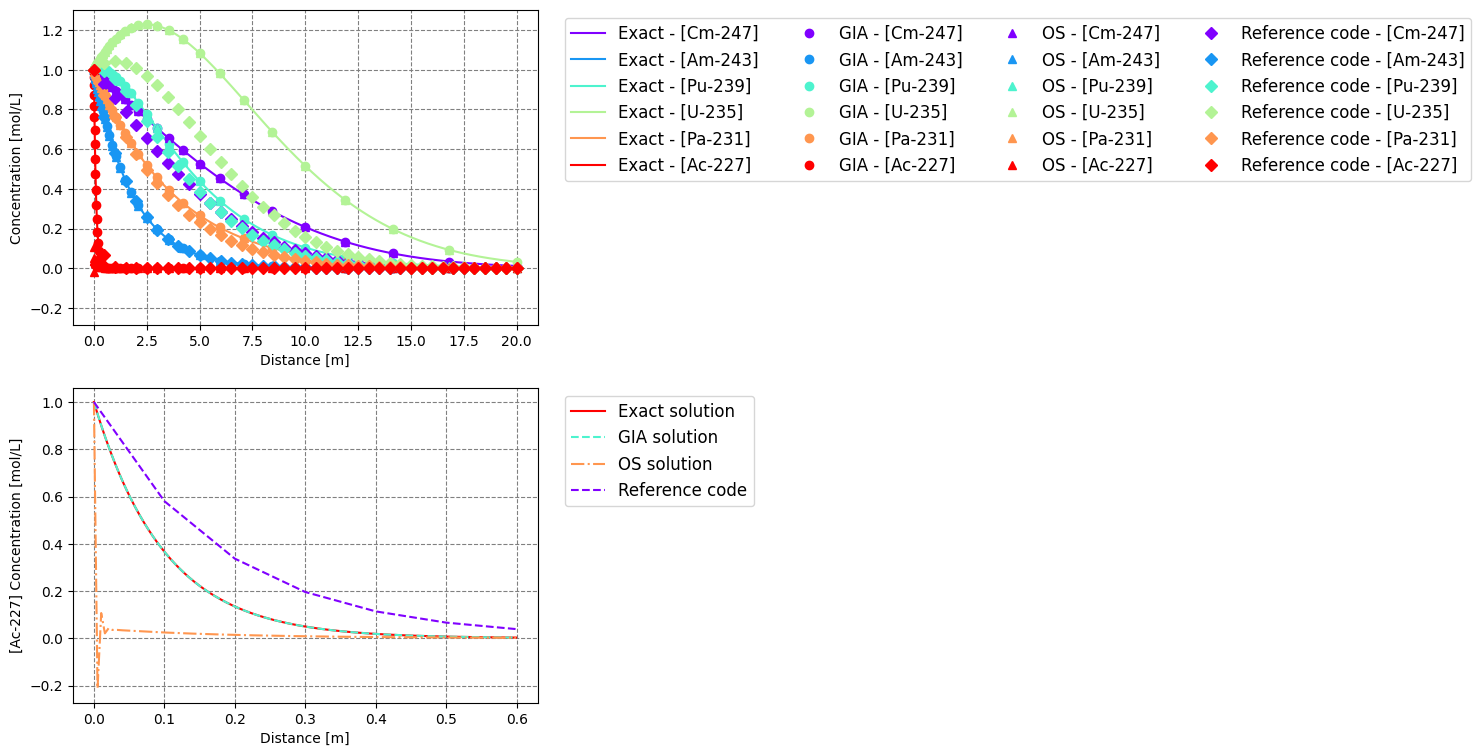

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

###Plot subfigure 1###
# ax1.set(xlim=(0, 20), ylim=(0, 1.4))
ax1.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

# Analytical solution
for radionuclide, color in zip(radionuclides, color_map):
    ax1.plot(
        x,
        c[radionuclide],
        linestyle="-",
        lw=1.5,
        label="Exact - " + radionuclide,
        c=color,
        zorder=10,
        # clip_on=False,
    )

# GIA numerical solution
for radionuclide, color in zip(radionuclides, color_map):
    c_gia = pvdfile_GIA.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax1.plot(
        x,
        c_gia,
        label="GIA - " + radionuclide,
        color=color,
        marker="o",
        markevery=50,
        linestyle="",
        zorder=10,
        # clip_on=False,
    )

# OS numerical solution
for radionuclide, color in zip(radionuclides, color_map):
    c_os = pvdfile_OS.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax1.plot(
        x,
        c_os,
        label="OS - " + radionuclide,
        color=color,
        marker="^",
        markevery=50,
        linestyle="",
        zorder=10,
        # clip_on=False,
    )

# numerical solution by reference code
# added once the bc value is double-checked
with h5py.File("./solution_reference_code.hdf5", "r") as f:
    species_ = f["species"][:]
    x_ = f["x"][:]
    for s_, radionuclide, color in zip(species_, radionuclides, color_map):
        data_ = f[s_][:]
        ax1.plot(
            x_,
            data_[:, 1] / porosity,
            label="Reference code - " + radionuclide,
            color=color,
            marker="D",
            markevery=5,
            linestyle="",
            zorder=10,
            # clip_on=False,
        )

ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=4)

ax1.xaxis.grid(color="gray", linestyle="dashed")
ax1.yaxis.grid(color="gray", linestyle="dashed")

###Plot subfigure 2###
# ax2.set(xlim=(0, 0.6), ylim=(0, 1.2))
ax2.set(xlabel="Distance [m]", ylabel="[Ac-227] Concentration [mol/L]")

# Analytical solution
ax2.plot(
    x[np.where(x < 0.6)],
    c["[Ac-227]"][np.where(x < 0.6)],
    linestyle="-",
    lw=1.5,
    label="Exact solution",
    c=color_map[-1],
    zorder=10,
    # clip_on=False,
)

# GIA numerical solution
Ac_227_gia = pvdfile_GIA.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax2.plot(
    x[np.where(x < 0.6)],
    Ac_227_gia[np.where(x < 0.6)],
    label="GIA solution",
    color=color_map[2],
    linestyle="--",
    zorder=10,
    # clip_on=False,
)

# OS numerical solution
Ac_227_os = pvdfile_OS.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax2.plot(
    x[np.where(x < 0.6)],
    Ac_227_os[np.where(x < 0.6)],
    label="OS solution",
    color=color_map[-2],
    linestyle="-.",
    zorder=10,
    clip_on=False,
)

# numerical solution by reference code
with h5py.File("./solution_reference_code.hdf5", "r") as f:
    Ac_227_ = f["species"][-1]
    x_ = f["x"][:]
    Ac_227_ = f[Ac_227_][:]
    ax2.plot(
        f["x"][np.where(x_ < 0.7)],
        Ac_227_[np.where(x_ < 0.7), 1][0] / porosity,
        label="Reference code",
        color=color_map[0],
        linestyle="--",
        zorder=10,
        clip_on=False,
    )

ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax2.xaxis.grid(color="gray", linestyle="dashed")
ax2.yaxis.grid(color="gray", linestyle="dashed")

As can be seen from Subfigure 1, for all radionuclides except the fastest decaying Actinium-227, the predicted concentration profiles using GIA and OS both agree well with the analytical solutions. For Actinium-227 concentration, the GIA solution perfectly matches with the reference result (see Subfigure 2). By contrast, the OS solution near the inlet deviates significantly from the reference result. The observed deviation is due to the fact that the time step size adopted in the simulation ($\Delta t$ = 100 years) is too large compared to the half-life of Actinium-227 ($t_{1/2}$ = 21.773 years).

### Molar fluxes (GIA simulation)

The following graph shows the molar fluxes obtained both analytically (solid lines) and numerically (GIA approach, thick, dotted lines).
It can be seen that both results coincide well.

In [13]:
grad_c = ana.computeGradients(x, t, v, D, k, radionuclides, c_inlet)
molar_flux_ana = {
    n: -porosity * diffusion_constant * grad_cs for n, grad_cs in grad_c.items()
}

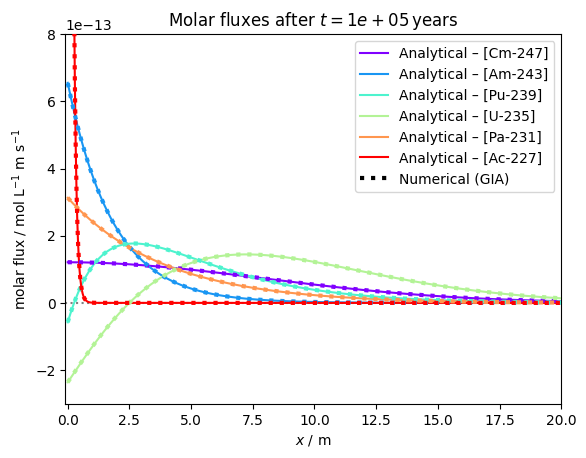

In [14]:
fig, ax1 = plt.subplots()

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

###Plot subfigure 1###
# ax1.set(xlim=(0, 20), ylim=(-1e-11, 1e-11))
ax1.set(xlabel="$x$ / m", ylabel="molar flux / mol L$^{-1}$ m s$^{-1}$")

# Analytical solution
for radionuclide, color in zip(radionuclides, color_map):
    ax1.plot(
        x,
        molar_flux_ana[radionuclide],
        linestyle="-",
        lw=1.5,
        label="Analytical – " + radionuclide,
        c=color,
        zorder=10,
        clip_on=True,
    )


# GIA numerical solution
for radionuclide, color in zip(radionuclides, color_map):
    c_gia = pvdfile_GIA.read_set_data(
        t * 3.1536e7,
        radionuclide + "Flux",
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax1.plot(
        x,
        c_gia,
        # label="GIA - " + radionuclide + "Flux",
        color=color,
        # marker="o",
        # markevery=50,
        linestyle=":",
        linewidth=3,
        zorder=10,
        clip_on=True,
    )

# compute axis limits
ax_min = sys.float_info.max
ax_max = sys.float_info.min
for radionuclide in radionuclides:
    q_min, q_max = np.quantile(molar_flux_ana[radionuclide], [0, 0.95])
    ax_min = min(ax_min, q_min)
    ax_max = max(ax_max, q_max)
ax_range = ax_max - ax_min
# ax1.set_ylim(ax_min - 0.025 * ax_range, ax_max + 0.025 * ax_range)
ax1.set_ylim(-3e-13, 8e-13)
ax1.set_xlim(-0.1, 20)

ax1.axhline(0, ls=":", color="gray")
ax1.set_title(rf"Molar fluxes after $t = {t:.0g}\,\mathrm{{years}}$")

handles, labels = ax1.get_legend_handles_labels()
handles.extend(
    [mpl.lines.Line2D([0], [0], label="Numerical (GIA)", color="k", ls=":", lw=3)]
)
ax1.legend(handles=handles);

### Error analysis

Furthermore, we perform an error analysis of the GIA and OS solutions. As can be observed from Subfigures 1 and 3, the absolute error of the GIA solution for all the radionuclides is suppressed at a low level. The maximum absolute error is only $3.6 \cdot 10^{-4}$  mol/L. In contrast, the absolute error of the OS solution is two to three orders of magnitude greater than that of the GIA solution (see Subfigures 2 and 3). And the error becomes more apparent closer to the inlet.

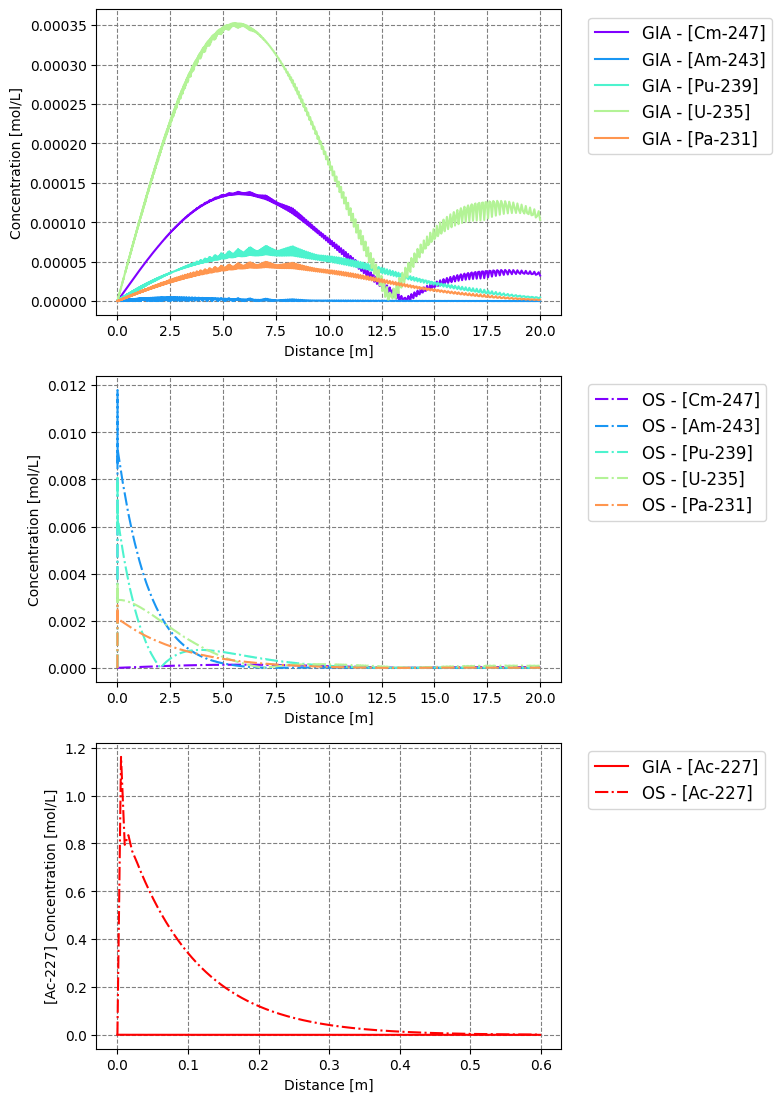

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 13.5))

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

###Plot subfigure 1###
# ax1.set(xlim=(0, 20), ylim=(0, 0.0005))
ax1.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

# GIA numerical solution
for radionuclide, color in zip(radionuclides[:-1], color_map):
    c_gia = pvdfile_GIA.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax1.plot(
        x,
        abs(c_gia - c[radionuclide]),
        label="GIA - " + radionuclide,
        color=color,
        linestyle="-",
        lw=1.5,
        zorder=10,
        clip_on=False,
    )

    assert np.all(np.abs(c_gia - c[radionuclide]) < 3.6e-4)

ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax1.xaxis.grid(color="gray", linestyle="dashed")
ax1.yaxis.grid(color="gray", linestyle="dashed")

###Plot subfigure 2###
# ax2.set(xlim=(0, 20), ylim=(0, 0.01))
ax2.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

# OS numerical solution
for radionuclide, color in zip(radionuclides[:-1], color_map):
    c_os = pvdfile_OS.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax2.plot(
        x,
        abs(c_os - c[radionuclide]),
        label="OS - " + radionuclide,
        color=color,
        linestyle="-.",
        lw=1.5,
        zorder=10,
        # clip_on=False,
    )

    assert np.all(np.abs(c_os - c[radionuclide]) < 0.012)

ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax2.xaxis.grid(color="gray", linestyle="dashed")
ax2.yaxis.grid(color="gray", linestyle="dashed")

###Plot subfigure 3###
# ax3.set(xlim=(0, 0.6), ylim=(0, 1.0))
ax3.set(xlabel="Distance [m]", ylabel="[Ac-227] Concentration [mol/L]")

# GIA numerical solution
Ac_227_gia = pvdfile_GIA.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax3.plot(
    x[np.where(x < 0.6)],
    abs(Ac_227_gia[np.where(x < 0.6)] - c["[Ac-227]"][np.where(x < 0.6)]),
    label="GIA - [Ac-227]",
    color=color_map[-1],
    linestyle="-",
    lw=1.5,
    zorder=10,
    # clip_on=False,
)

# OS numerical solution
Ac_227_os = pvdfile_OS.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax3.plot(
    x[np.where(x < 0.6)],
    abs(Ac_227_os[np.where(x < 0.6)] - c["[Ac-227]"][np.where(x < 0.6)]),
    label="OS - [Ac-227]",
    color=color_map[-1],
    linestyle="-.",
    lw=1.5,
    zorder=10,
    # clip_on=False,
)

ax3.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax3.xaxis.grid(color="gray", linestyle="dashed")
ax3.yaxis.grid(color="gray", linestyle="dashed")

#### Molar fluxes

The following plots show the difference between numerically computed molar fluxes (OGS, GIA approach) and analytically derived fluxes (left plot),
and that difference normalized to the range of analytical concentration gradients (right plot).
That normalized error is smaller than 0.1 % for all nuclides.

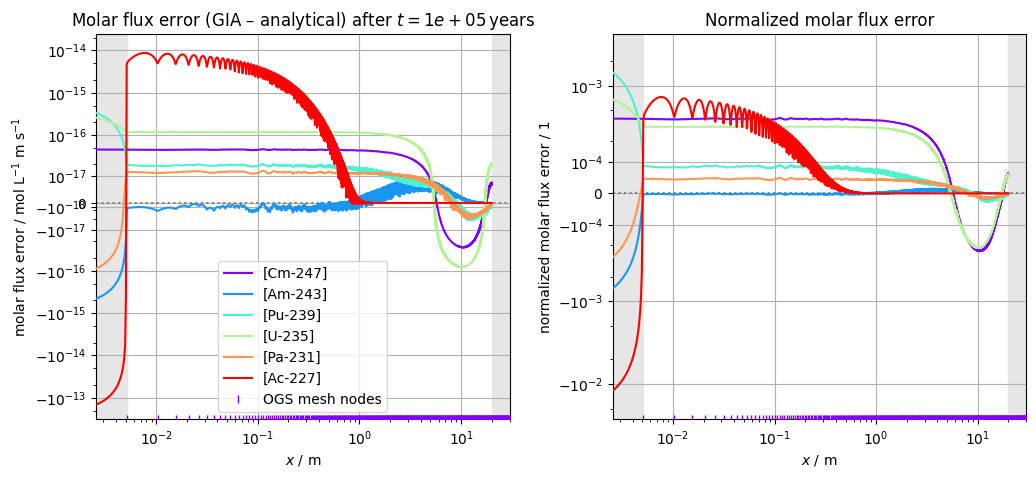

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
fig.subplots_adjust(wspace=0.25)

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

###Plot subfigure 1###
ax1.set(xlabel="$x$ / m", ylabel=r"molar flux error / mol L$^{-1}$ m s$^{-1}$")

ax_min = sys.float_info.max
ax_max = sys.float_info.min

check_x_selection = x >= x_mesh[1]

# difference GIA minus analytical
for radionuclide, color in zip(radionuclides, color_map):
    c_gia = pvdfile_GIA.read_set_data(
        t * 3.1536e7,
        radionuclide + "Flux",
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    c_ana = molar_flux_ana[radionuclide]

    delta_c = c_gia - c_ana

    ax1.plot(
        x,
        delta_c,
        label=radionuclide,
        color=color,
        # marker=".",
        # markevery=50,
        # linestyle=":",
        # linewidth=3,
        zorder=10,
        clip_on=True,
    )

    c_ana_min = np.min(c_ana)
    c_ana_max = np.max(c_ana)
    c_ana_range = c_ana_max - c_ana_min

    delta_c_normalized = delta_c / c_ana_range

    ax2.plot(
        x,
        delta_c_normalized,
        label=radionuclide,
        color=color,
        # marker=".",
        # markevery=50,
        # linestyle=":",
        # linewidth=3,
        zorder=10,
        clip_on=True,
    )

    assert np.all(np.abs(delta_c_normalized[check_x_selection]) < 8e-4)

    # compute axis range for ax1
    qmin, qmax = np.quantile(delta_c, [0.05, 1])
    ax_min = min(ax_min, qmin)
    ax_max = max(ax_max, qmax)

# ax_range = ax_max - ax_min
# ax1.set_ylim(ax_min - 0.025 * ax_range, ax_max + 0.025 * ax_range)
# ax1.set_ylim(-2e-17, 1.1*ax_max)

ax1.axhline(0, ls=":", color="gray")
ax1.set_title(
    rf"Molar flux error (GIA – analytical) after $t = {t:.0g}\,\mathrm{{years}}$"
)

trans1 = mpl.transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.plot(
    x_mesh,
    0 * x_mesh,
    scalex=False,
    ls="",
    marker="|",
    color=color_map[0],
    label="OGS mesh nodes",
    zorder=50,
    transform=trans1,
)

trans2 = mpl.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
ax2.plot(
    x_mesh,
    0 * x_mesh,
    scalex=False,
    ls="",
    marker="|",
    color=color_map[0],
    label="OGS mesh nodes",
    zorder=50,
    transform=trans2,
)

ax1.legend()

ax2.set_title(r"Normalized molar flux error")
ax2.set(xlabel="$x$ / m", ylabel=r"normalized molar flux error / 1")
ax2.axhline(0, ls=":", color="gray")

ax1.set_xscale("log")
ax1.set_xlim(0.5 * x_mesh[1], 1.5 * x[-1])
ax1.axvspan(0.5 * x_mesh[1], x_mesh[1], alpha=1, color="0.9")
ax1.axvspan(x[-1], 1.5 * x[-1], alpha=1, color="0.9")
ax1.set_yscale("asinh", linear_width=5e-18)
ax1.grid()

ax2.set_xscale("log")
ax2.set_xlim(0.5 * x_mesh[1], 1.5 * x[-1])
ax2.axvspan(0.5 * x_mesh[1], x_mesh[1], alpha=1, color="0.9")
ax2.axvspan(x[-1], 1.5 * x[-1], alpha=1, color="0.9")
ax2.set_yscale("asinh", linear_width=1e-4)
ax2.grid()

Molar fluxes are a secondary quantity in OGS.
They are computed at the integration points of each mesh element and extrapolated to the mesh nodes for output purposes.
The contributions to the nodal values from each adjacent mesh element are averaged.
This extrapolation and averaging procedure leads to errors itself.  
OGS computes an error indicator for the extrapolation and averaging error.
This indicator is the root mean square error when re-interpolating the extrapolated and averaged molar fluxes back to the integration points.
It is computed as a cell field.  
It is shown for all nuclides in the plots below.
The left plot shows the extrapolation residuals, the right one the extrapolation residuals normalized to the range of molar fluxes.
That normalized error is smaller than 0.23 % for all nuclides but Ac-227, for which it is smaller than 1.5 %.
The error estimate is larger — in the Ac-227 case much larger — than the actual error.
I.e., in this case, it is a conservative estimate of the actual error, but it's worthwhile to reconsider this on a case-by-case basis.

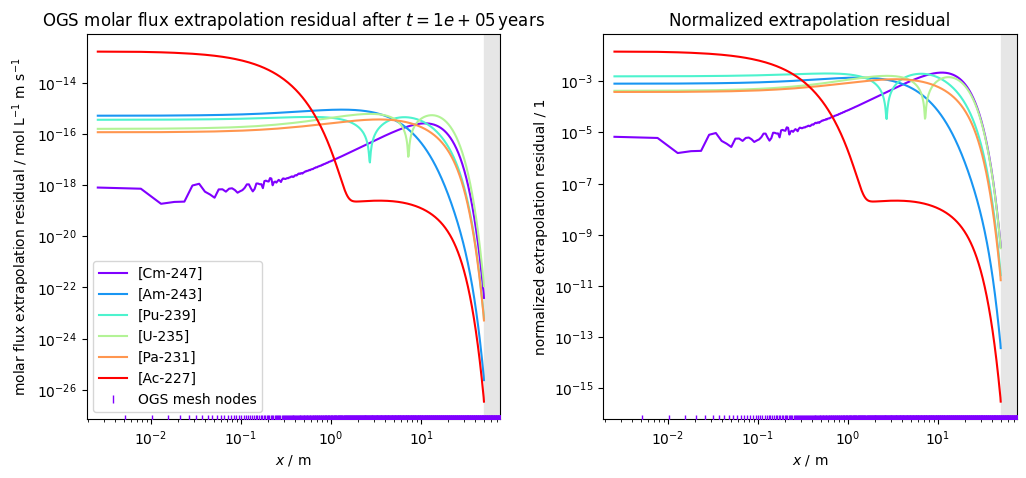

In [17]:
###Read simulation results###
reader = pv.get_reader(f"{out_dir}/{prj_name}_GIA.pvd")
reader.set_active_time_point(-1)
assert reader.active_time_value == t * 3.1536e7

mesh = reader.read()[0]
x_mesh2 = mesh.points[:, 0]
# only keep [0, 50] meter range
xmax = 50
mesh = mesh.clip(origin=(xmax, 0, 0), normal="x", invert=True)
mesh = mesh.cell_centers(vertex=False)

x_center2 = mesh.points[:, 0]
assert np.all(np.diff(x_center2) > 0)
grad_c2 = ana.computeGradients(x_center2, t, v, D, k, radionuclides, c_inlet)
molar_flux_ana2 = {
    n: -porosity * diffusion_constant * grad_cs for n, grad_cs in grad_c2.items()
}

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
fig.subplots_adjust(wspace=0.25)

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

###Plot subfigure 1###
ax1.set(
    xlabel="$x$ / m",
    ylabel=r"molar flux extrapolation residual / mol L$^{-1}$ m s$^{-1}$",
)

ax_min = sys.float_info.max
ax_max = sys.float_info.min

x_mid = 0.5 * (x[1:] + x[:-1])

# difference GIA minus analytical
for radionuclide, color in zip(radionuclides, color_map):
    c_gia = mesh.point_data[radionuclide + "Flux_residual"]
    c_ana = molar_flux_ana2[radionuclide]

    ax1.plot(
        x_center2,
        c_gia,
        label=radionuclide,
        color=color,
        # marker="o",
        # markevery=50,
        # linestyle=":",
        # linewidth=3,
        zorder=10,
        clip_on=True,
    )

    c_ana_min = np.min(c_ana)
    c_ana_max = np.max(c_ana)
    c_ana_range = c_ana_max - c_ana_min

    delta_c = c_gia
    delta_c_normalized = delta_c / c_ana_range

    # print(f"{radionuclide:10} | c_ana_range={c_ana_range:.3g} | max abs delta_c={np.max(np.abs(delta_c)):.3g}")

    ax2.plot(
        x_center2,
        delta_c_normalized,
        label=radionuclide,
        color=color,
        # marker="o",
        # markevery=50,
        # linestyle=":",
        # linewidth=3,
        zorder=10,
        clip_on=True,
    )

    if radionuclide != "[Ac-227]":
        assert np.all(np.abs(delta_c_normalized) < 0.0023)
    assert np.all(np.abs(delta_c_normalized) < 1.5e-2)
    # print(radionuclide, np.max(np.abs(delta_c_normalized)))

    # compute axis range for ax1
    qmin, qmax = np.quantile(c_gia, [0.05, 0.90])
    ax_min = min(ax_min, qmin)
    ax_max = max(ax_max, qmax)

ax_range = ax_max - ax_min
# ax1.set_ylim(ax_min - 0.025*ax_range, ax_max + 0.025*ax_range)
ax1.set_yscale("log")
# ax1.set_ylim(0, 1.2e-16)
# ax1.set_ylim(1e-32)
# ax1.set_xlim(-1, 50)

ax1.axhline(0, ls=":", color="gray")
ax1.set_title(
    rf"OGS molar flux extrapolation residual after $t = {t:.0g}\,\mathrm{{years}}$"
)

trans1 = mpl.transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
ax1.plot(
    x_mesh2,
    0 * x_mesh2,
    scalex=False,
    ls="",
    marker="|",
    color=color_map[0],
    label="OGS mesh nodes",
    zorder=50,
    transform=trans1,
)

trans2 = mpl.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
ax2.plot(
    x_mesh2,
    0 * x_mesh2,
    scalex=False,
    ls="",
    marker="|",
    color=color_map[0],
    label="OGS mesh nodes",
    zorder=50,
    transform=trans2,
)

ax1.legend()

ax2.set(xlabel="$x$ / m", ylabel=r"normalized extrapolation residual / 1")
ax2.set_title(r"Normalized extrapolation residual")
ax2.set_yscale("log")

ax1.set_xscale("log")
ax1.set_xlim(0.75 * x_center2[0], 1.5 * xmax)
# ax1.axvspan(0.5 * x_center2[1], x_center2[1], alpha=1, color='0.9');
ax1.axvspan(x_center2[-1], 1.5 * xmax, alpha=1, color="0.9")

ax2.set_xscale("log")
ax2.set_xlim(0.75 * x_center2[0], 1.5 * x_center2[-1])
# ax2.axvspan(0.5 * x_center2[1], x_center2[1], alpha=1, color='0.9');
ax2.axvspan(x_center2[-1], 1.5 * xmax, alpha=1, color="0.9");

#### The effect of time step size

As shown in the figure below, the OS solution is rather sensitive to the time stepping scheme. By reducing the time step size from 100 years to 5 years, the solution accuracy near the inlet is greatly improved. Nevertheless, the OS solution accuracy is yet lower than that of the GIA solution despite a larger time step size.

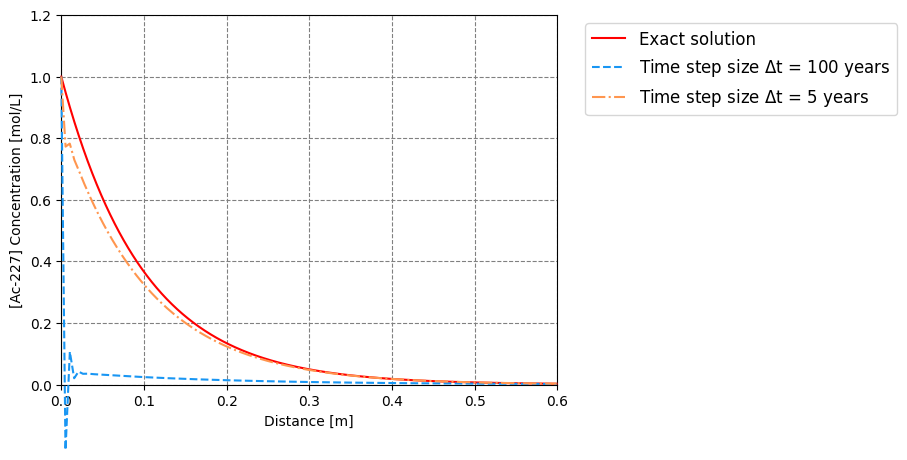

In [18]:
###Read OS solution with a smaller time step size###
pvdfile_OS_small_ts = vtuIO.PVDIO(f"./{prj_name}_OS_5year.pvd", dim=1)

###Plot figure###
fig, ax = plt.subplots()

ax.set(xlim=(0, 0.6), ylim=(0, 1.2))
ax.set(xlabel="Distance [m]", ylabel="[Ac-227] Concentration [mol/L]")

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

# Analytical solution
ax.plot(
    x[np.where(x < 0.6)],
    c["[Ac-227]"][np.where(x < 0.6)],
    linestyle="-",
    lw=1.5,
    label="Exact solution",
    color=color_map[-1],
    zorder=10,
    clip_on=False,
)

# OS solution with a time step size of 100 years
Ac_227_os = pvdfile_OS.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax.plot(
    x[np.where(x < 0.6)],
    Ac_227_os[np.where(x < 0.6)],
    label=r"Time step size $\Delta$t = 100 years",
    color=color_map[1],
    linestyle="--",
    zorder=10,
    clip_on=False,
)

# OS solution with a time step size of 5 years
Ac_227_os_small_ts = pvdfile_OS_small_ts.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax.plot(
    x[np.where(x < 0.6)],
    Ac_227_os_small_ts[np.where(x < 0.6)],
    label=r"Time step size $\Delta$t = 5 years",
    color=color_map[-2],
    linestyle="-.",
    zorder=10,
    clip_on=False,
)

ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax.xaxis.grid(color="gray", linestyle="dashed")
ax.yaxis.grid(color="gray", linestyle="dashed")

## Computational performance of two solution strategies

The runtime of the GIA model is only 22.13 seconds, approximately two orders of magnitude faster than the OS model in this case (see the figure below). Further time profiling analysis for the OS model indicates that PHREEQC consumes over 90 percent of the runtime for solving the local decay-chain problem.

mpirun --bind-to none -np 4 ogs ./GlobalImplicitApproach/MPI/4Processors/1d_decay_chain_GIA.prj -o _out > out.txt
Execution time for the parallelized GIA model with 4 processors is  91.26 s
mpirun --bind-to none -np 8 ogs ./GlobalImplicitApproach/MPI/8Processors/1d_decay_chain_GIA.prj -o _out > out.txt
--------------------------------------------------------------------------
There are not enough slots available in the system to satisfy the 8
slots that were requested by the application:

  ogs

Either request fewer procs for your application, or make more slots
available for use.

A "slot" is the PRRTE term for an allocatable unit where we can
launch a process.  The number of slots available are defined by the
environment in which PRRTE processes are run:

  1. Hostfile, via "slots=N" clauses (N defaults to number of
     processor cores if not provided)
  2. The --host command line parameter, via a ":N" suffix on the
     hostname (N defaults to 1 if not provided)
  3. Resource manag

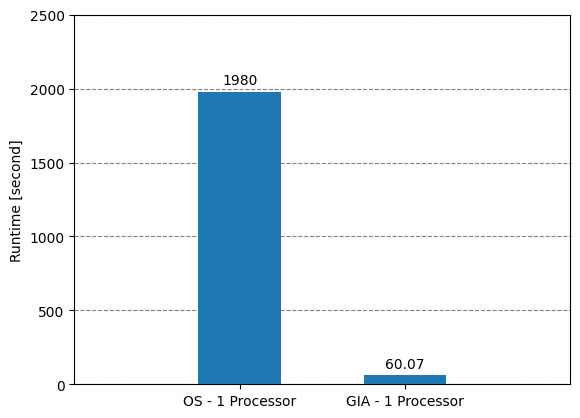

In [19]:
prj_file_GIA_4 = f"./GlobalImplicitApproach/MPI/4Processors/{prj_name}_GIA.prj"
prj_file_GIA_8 = f"./GlobalImplicitApproach/MPI/8Processors/{prj_name}_GIA.prj"

print(f"mpirun --bind-to none -np 4 ogs {prj_file_GIA_4} -o {out_dir} > out.txt")
start_time = time.time()
! mpirun --bind-to none -np 4 ogs {prj_file_GIA_4} -o {out_dir} > {out_dir}/out.txt
end_time = time.time()
runtime_GIA_4 = round(end_time - start_time, 2)
print(
    "Execution time for the parallelized GIA model with 4 processors is ",
    runtime_GIA_4,
    "s",
)

print(f"mpirun --bind-to none -np 8 ogs {prj_file_GIA_8} -o {out_dir} > out.txt")
start_time = time.time()
! mpirun --bind-to none -np 8 ogs {prj_file_GIA_8} -o {out_dir} > {out_dir}/out.txt
end_time = time.time()
runtime_GIA_8 = round(end_time - start_time, 2)
print(
    "Execution time for the parallelized GIA model with 8 processors is ",
    runtime_GIA_8,
    "s",
)

# runtime [second]
runtime = {
    "OS - 1 Processor": 1980,
    "GIA - 1 Processor": runtime_GIA,
    "GIA - 4 Processor": runtime_GIA_4,
    "GIA - 8 Processor": runtime_GIA_8,
}

###Plot figure###
fig, ax = plt.subplots()

ax.set(xlim=(-1, 2), ylim=(0, 2500))

ax.set_ylabel("Runtime [second]")
ax.set_yticks(np.arange(0, 3000, 500))

ax.yaxis.grid(color="gray", linestyle="dashed", zorder=0)

ax.bar(list(runtime.keys())[:2], list(runtime.values())[:2], width=0.5, zorder=3)

for i in range(2):
    ax.annotate(
        list(runtime.values())[i], (i, list(runtime.values())[i] + 50), ha="center"
    )

To summarize, the global implicit approach (GIA) is clearly superior to the operator splitting approach in terms of solution accuracy and computational performance. Moreover, the global implicit approach even allows for a larger time step size.

### The effect of parallelization on computational performance

In order to further improve the computational performance of the GIA model, MPI parallelization is employed. As its result, the simulation runtime is drastically reduced down to 4.82 seconds with the number of processors increased to 8. This results in a 4.6X  speed boost.

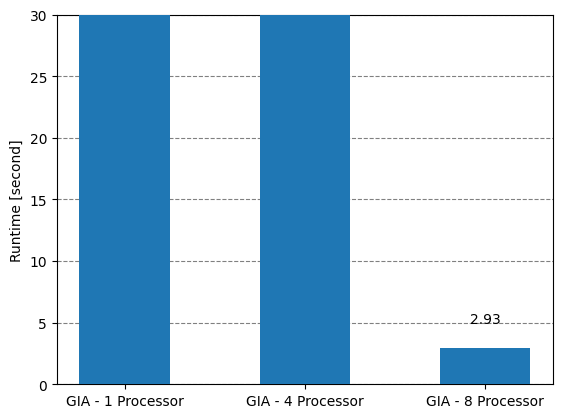

In [20]:
###Plot figure###
fig, ax = plt.subplots()

ax.set(ylim=(0, 30))

ax.set_ylabel("Runtime [second]")
ax.yaxis.grid(color="gray", linestyle="dashed", zorder=0)

ax.bar(list(runtime.keys())[1:], list(runtime.values())[1:], width=0.5, zorder=3)

for i in range(1, 4):
    ax.annotate(
        list(runtime.values())[i], (i - 1, list(runtime.values())[i] + 2), ha="center"
    )

## References

<a href="https://www.grs.de/de/aktuelles/publikationen/grs-289-vsg-radiologische-konsequenzenanalyse-ap-10">(GRS 289)</a> VSG: Radiologische Konsequenzenanalyse (AP 10). J. Larue, B. Baltes, H. Fischer, G. Frieling, I. Kock, M. Navarro, H. Seher.

Sun, Y., Petersen, J. N., & Clement, T. P. (1999). Analytical solutions for multiple species reactive transport in multiple dimensions. Journal of Contaminant Hydrology, 35(4), 429-440.

**Credits:**

Renchao Lu, Christoph Behrens, Dmitri Naumov, Christoph Lehmann, Haibing Shao